In [ ]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as web
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Download training and testing data
data= yf.download('MSFT', start="2020-01-01", end="2024-01-01")


[*********************100%%**********************]  1 of 1 completed


In [ ]:
data.isnull().sum()/len(data)

Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64

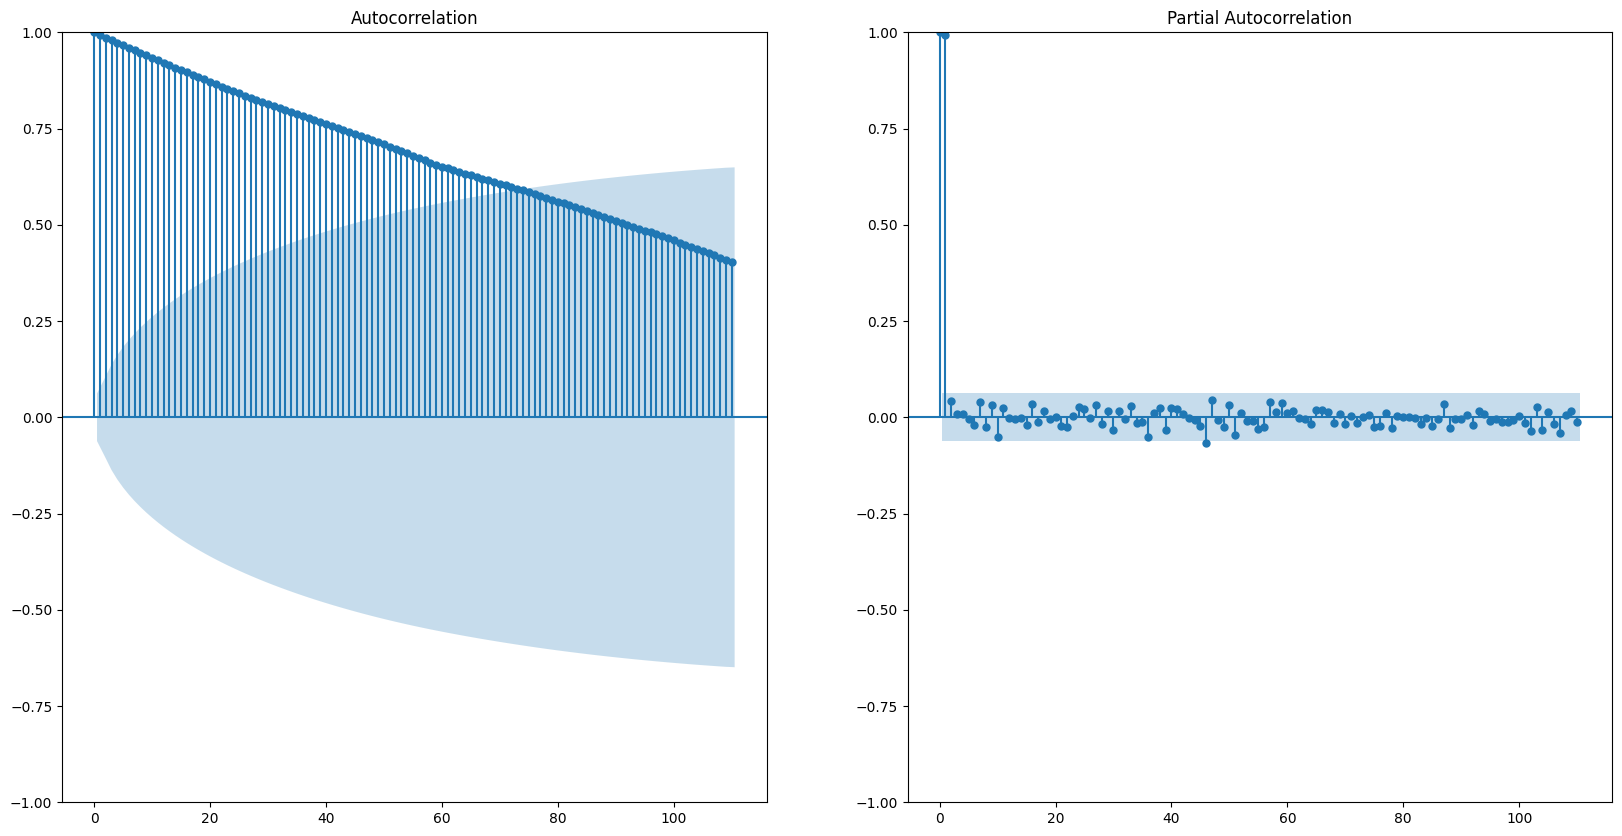

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF and PACF to help determine ARIMA parameters
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
plot_acf(data['Adj Close'].dropna(), lags = 110 ,ax=ax[0])
plot_pacf(data['Adj Close'].dropna(), lags = 110,ax=ax[1])
plt.show()

In [ ]:
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

check_stationarity(data['Adj Close'])

ADF Statistic: -0.999180
p-value: 0.753563
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


In [ ]:
# Differencing if non-stationary
if data['Adj Close'][1] > 0.05:  # Using a common significance level of 5%
    data['Differenced'] = data['Adj Close'].diff().dropna()
    check_stationarity(data['Differenced'])
else:
    data['Differenced'] = data['Adj Close']

ADF Statistic: -10.278722
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


In [ ]:
data

,Open,High,Low,Close,Adj Close,Volume,Differenced
Date,,,,,,,
2020-01-02,158.779999,160.729996,158.330002,160.619995,154.493820,22622100,NaN
2020-01-03,158.320007,159.949997,158.059998,158.619995,152.570084,21116200,-1.923737
2020-01-06,157.080002,159.100006,156.509995,159.029999,152.964462,20813700,0.394379
2020-01-07,159.320007,159.669998,157.320007,157.580002,151.569763,21634100,-1.394699
2020-01-08,158.929993,160.800003,157.949997,160.089996,153.984039,27746500,2.414276
...,...,...,...,...,...,...,...
2023-12-22,373.679993,375.179993,372.709991,374.579987,373.888580,17091100,1.038055
2023-12-26,375.000000,376.940002,373.500000,374.660004,373.968445,12673100,0.079865
2023-12-27,373.690002,375.059998,372.809998,374.070007,373.379547,14905400,-0.588898


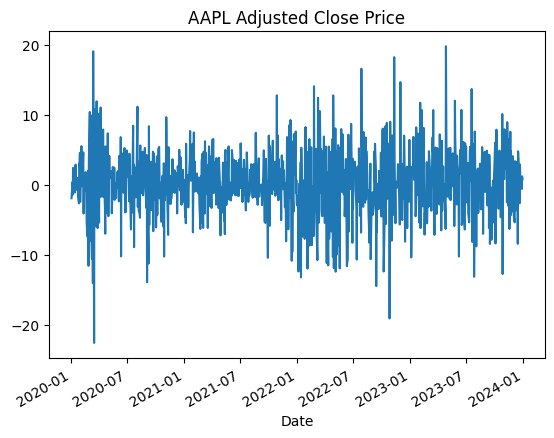

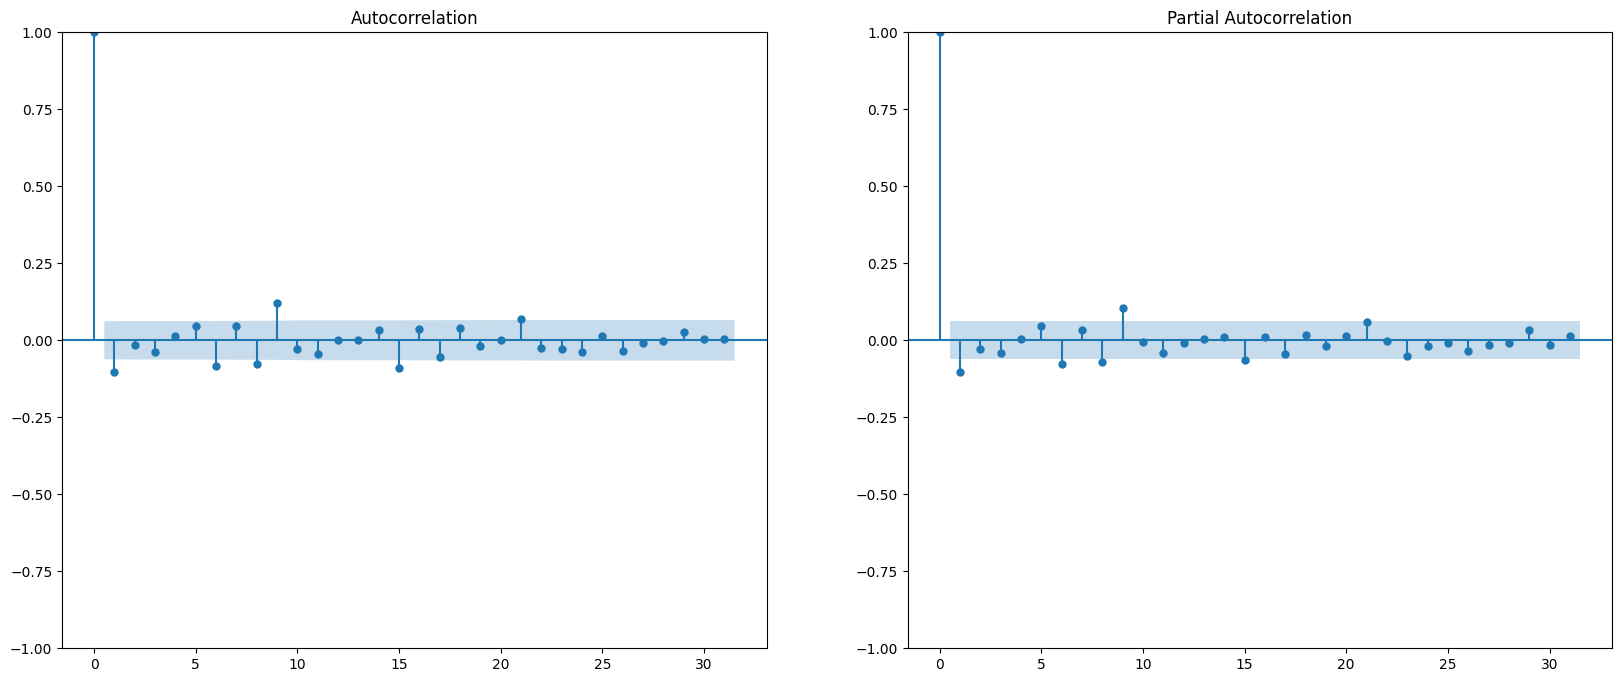

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Ensure your DataFrame is indexed by date for time series analysis
data['Differenced'].plot(title='AAPL Adjusted Close Price')
plt.show()


# Plot ACF and PACF to help determine ARIMA parameters
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
plot_acf(data['Differenced'].dropna(), ax=ax[0])
plot_pacf(data['Differenced'].dropna(), ax=ax[1])
plt.show()

<Figure size 640x480 with 0 Axes>

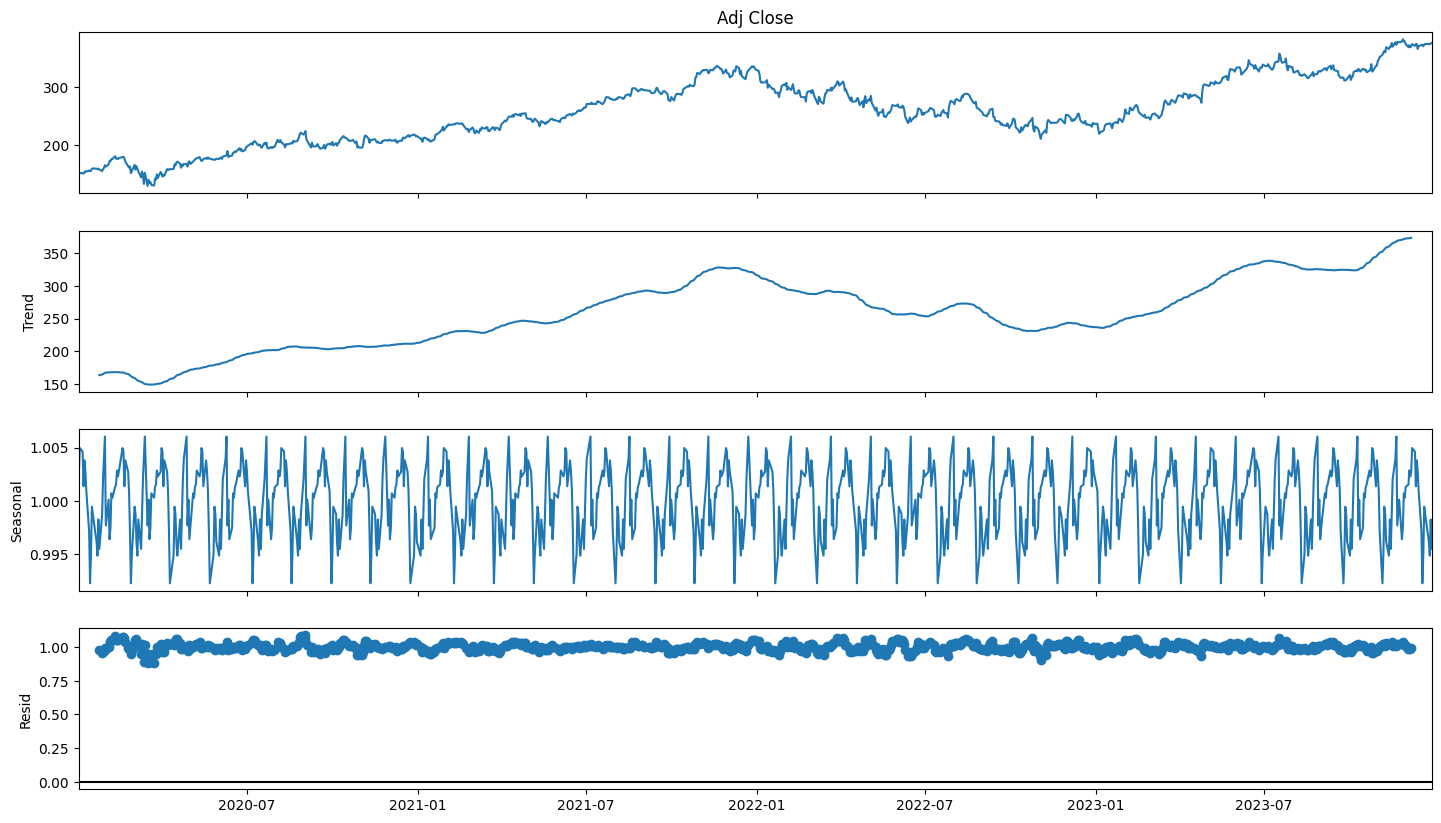

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(data['Adj Close'],model= 'multiplicative', period=30)
fig=plt.figure()
fig=result.plot()
fig.set_size_inches(16,9)

## Check Different ARIMA

In [ ]:
split_point = int(len(data) * 0.8)
training_set, test_set = data[:split_point], data[split_point:]


In [ ]:
import statsmodels.api as sm

from statsmodels.tsa.arima.model import ARIMA

# Assume p, d, and q have been chosen based on diagnostic checks such as ACF and PACF plots
model = ARIMA(training_set['Differenced'], order=(1,1,0))


# Fit the ARIMA model
model_fit = model.fit()


# Print out the summary of the model's performance
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            Differenced   No. Observations:                  804
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2571.155
Date:                Sun, 14 Apr 2024   AIC                           5146.310
Time:                        03:15:18   BIC                           5155.687
Sample:                             0   HQIC                          5149.912
                                - 804                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5517      0.023    -23.803      0.000      -0.597      -0.506
sigma2        34.9531      1.250     27.954      0.000      32.502      37.404
Ljung-Box (L1) (Q):                  27.14   Jarque-

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Predict on the test set
predictions0 = model_fit.predict(start=len(training_set), end=len(training_set) + len(test_set) - 1, typ='levels')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [ ]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(test_set['Differenced'], predictions0))
print(f'Test RMSE: {rmse}')

Test RMSE: 4.9497609762640336


In [ ]:
import statsmodels.api as sm

from statsmodels.tsa.arima.model import ARIMA

# Assume p, d, and q have been chosen based on diagnostic checks such as ACF and PACF plots
model = ARIMA(training_set['Differenced'], order=(1,1,1))


# Fit the ARIMA model
results2 = model.fit()


# Print out the summary of the model's performance
print(results2.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            Differenced   No. Observations:                  804
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2394.883
Date:                Sun, 14 Apr 2024   AIC                           4795.767
Time:                        03:15:34   BIC                           4809.832
Sample:                             0   HQIC                          4801.169
                                - 804                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1109      0.028     -3.995      0.000      -0.165      -0.056
ma.L1         -0.9988      0.007   -140.720      0.000      -1.013      -0.985
sigma2        22.3600      0.889     25.158      0.0

In [ ]:
# Predict on the test set
predictions2 = results2.predict(start=len(training_set), end=len(training_set) + len(test_set) - 1, typ='levels')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [ ]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(test_set['Differenced'], predictions2))
print(f'Test RMSE: {rmse}')

Test RMSE: 4.743621267984704


In [ ]:
import statsmodels.api as sm

from statsmodels.tsa.arima.model import ARIMA

# Assume p, d, and q have been chosen based on diagnostic checks such as ACF and PACF plots
model = ARIMA(training_set['Differenced'], order=(2,1,1))


# Fit the ARIMA model
model_fit0 = model.fit()


# Print out the summary of the model's performance
print(model_fit0.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            Differenced   No. Observations:                  804
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2394.862
Date:                Sun, 14 Apr 2024   AIC                           4797.723
Time:                        03:15:49   BIC                           4816.477
Sample:                             0   HQIC                          4804.926
                                - 804                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1117      0.029     -3.905      0.000      -0.168      -0.056
ar.L2         -0.0074      0.029     -0.256      0.798      -0.064       0.049
ma.L1         -0.9987      0.007   -149.330      0.0

In [ ]:
# Predict on the test set
predictions3 = model_fit0.predict(start=len(training_set), end=len(training_set) + len(test_set) - 1, typ='levels')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [ ]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(test_set['Differenced'], predictions3))
print(f'Test RMSE: {rmse}')

Test RMSE: 4.743886972519178


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
num_lags = 5  # Number of lagged features to create
for i in range(1, num_lags + 1):
    data[f'Adj Close Lag {i}'] = data['Adj Close'].shift(i)
    # Include other features if desired, e.g., train_df[f'Volume Lag {i}'] = train_df['Volume'].shift(i)

# Drop the rows with NaN values resulting from the shifting
train_df = train_df.dropna()

# Separate the dataset into features and the target variable
features = train_df.drop(['Close', 'Adj Close'], axis=1)  # 'Close' is dropped because 'Adj Close' is a better representation
target = train_df['Adj Close']

# Split the data into training and testing sets
split_point = int(len(train_df) * 0.8)
X_train, X_test = features[:split_point], features[split_point:]
y_train, y_test = target[:split_point], target[split_point:]